In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.feature import peak_local_max

%matplotlib inline

In [8]:
def laplace_of_gaussian(s):
    half_width = round(3 * s)  # Half width of kernel
    X, Y = np.meshgrid(np.arange(-half_width, half_width + 1, 1), np.arange(-half_width, half_width + 1, 1))

    log_kernel = ((X**2 + Y**2) / (2 * s**2) - 1) * np.exp(-(X**2 + Y**2) / (2 * s**2)) / (np.pi * s**4)
    return log_kernel

In [9]:
def detect_max(img1_log, sigma):
    coordinates = []
    (h, w) = img1_log.shape
    k = 1
    for i in range(k, h-k):
        for j in range(k, w-k):
            slice_img = img1_log[i-k:i+k+1, j-k:j+k+1]
            result = np.max(slice_img)  # finding maximum
            if result >= 0.09:  # threshold
                x, y = np.unravel_index(slice_img.argmax(), slice_img.shape)
                coordinates.append((i+x-k, j+y-k))  # finding coordinates
    return set(coordinates)

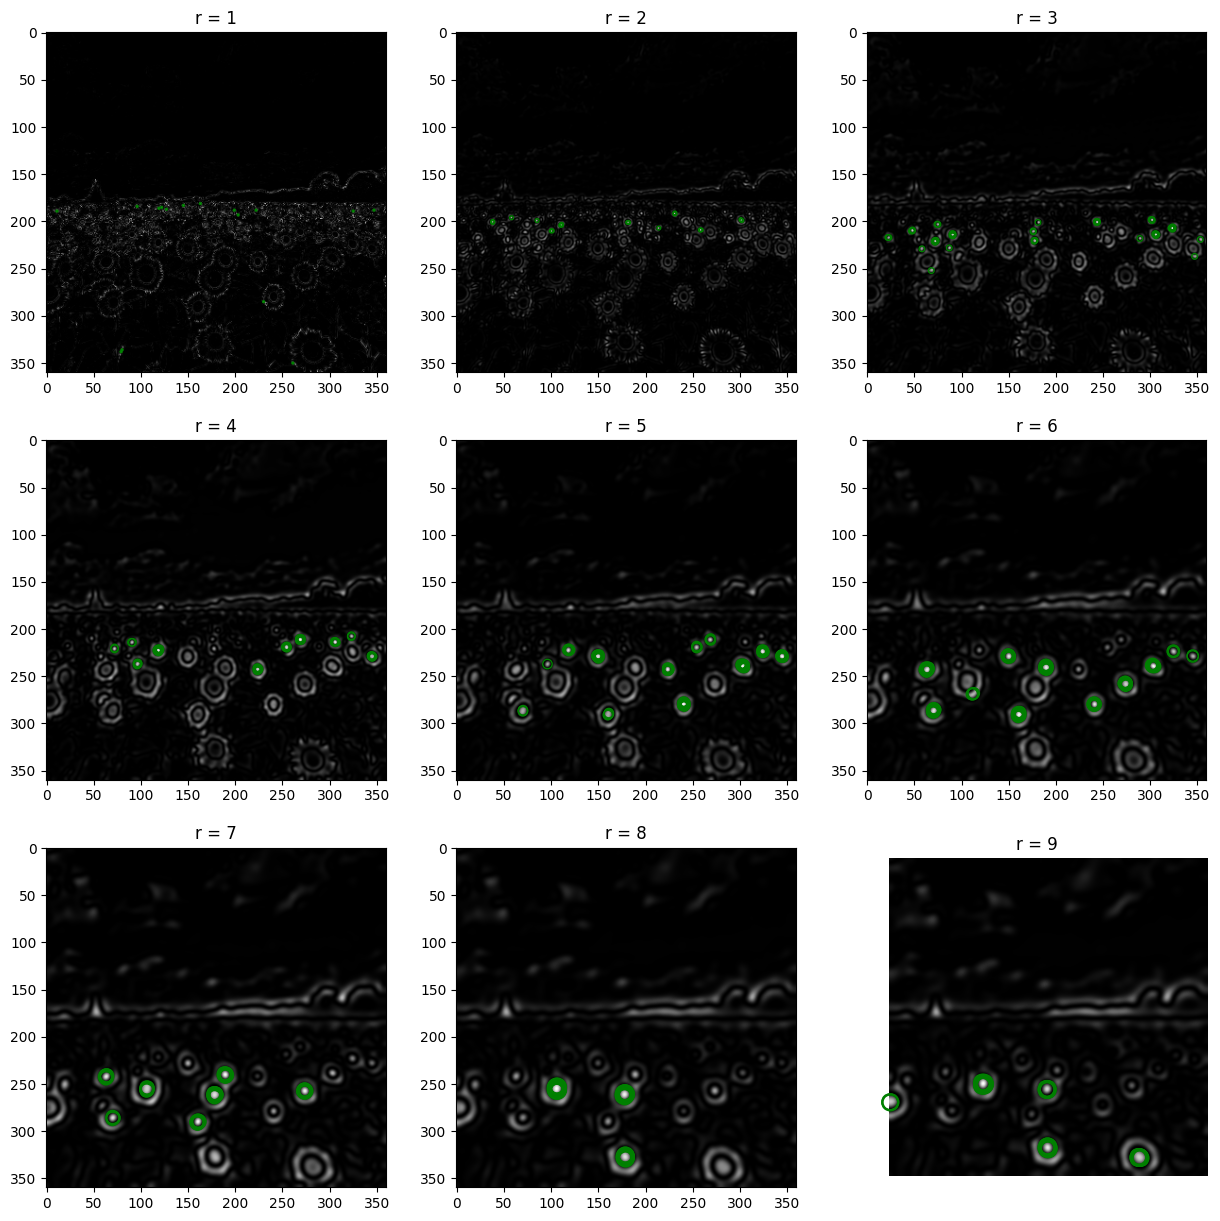

In [10]:
img1 = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY) / 255

fig, axes = plt.subplots(3, 3, figsize = (15, 15))

# Finding local peaks for each sigma
for r, ax in enumerate(axes.flatten(), start = 1):
    sigma = r/1.414
    LOG = sigma**2 * laplace_of_gaussian(sigma)
    img1_log = np.square(cv.filter2D(img1, -1, LOG))

    coordinates = detect_max(img1_log, sigma)

    ax.imshow(img1_log, cmap = 'gray')
    ax.set_title(f'r = {r}')

    for x, y in coordinates:
        c = plt.Circle((y, x), sigma * 1.414, color = 'g', linewidth=1, fill=False)
        ax.add_patch(c)
    ax.plot()
    plt.axis('off')